### Capston Project: Identify Fraudulent Transaction

**Author:** Despoina Moschou

**e-mail:** dspmoschou@gmail.com

**Date created**: 19-04-2023

In [52]:
import pandas as pd
import numpy as np
import matplotlib
import typing as t
import time
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    roc_curve,
    roc_auc_score,
    recall_score,
)


### Background

As part of the Capstone project for the Certificate in Artificial Intelligence from the Imperial College of London, I decided to work on classification problems.  

For this activity I choose to use the Credit Card Fraud detection dataset, that is published on Kaggle (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). This dataset contains transactions made by credit cards in September 2013 by European cardholders. All data are anonymised (provided predictors are principal components obtained with PCA), and we have no information about the originial features and their background.

The aim of this activity is to create a binary classifier that given a transaction is able to answer with precision the question: "Is this transaction fraudulent?"

Note: This dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.

### Exploratory Data Analysis

Based on the Kaggle we know that:
* Predictors V1-V28 are principal components of a PCA. No further information are given.
* The Time predictor contains the seconds elapsed between each transaction and the first transaction in the dataset.
* The Amount predictor is the transaction amount and is a cost-sensitive feature.
* The Class column is the target column and it takes the value 1 if the transaction is a fraud otherwise 0.

Also, we are expecting the dataset to be highly imbalance and only ~0.2% of the data to represent fraudulent transactions (minority group).  

Let's load the data and investigate the above claims.

In [2]:
cd ..

/Users/despoinamoschou/Desktop/DS Learning/fraud_detection


In [3]:
data = pd.read_csv("data/creditcard.csv")
data.head(3)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [4]:
print(
    f"The credit card dataset has {data.shape[0]} entries and {data.shape[1]-1} predictors"
)


The credit card dataset has 284807 entries and 30 predictors


In [5]:
data.describe()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


We know that predictors V1-V28 are the results of a PCA transformation and we don't have furthure information about them, so we can't feature engineer them. As they are products of a PCA trnasformation and based on their statistics, we know that they have been standarized. Therfore we will need to perform standarization on the Amount and Time predictors.

In [6]:
scaler = StandardScaler()
data["Amount"] = scaler.fit_transform(data[["Amount"]])
data["Time"] = scaler.fit_transform(data[["Time"]])


Check for missing values in dataset.

In [7]:
print(f"There are {data.isna().sum().sum()} missing values in the dataset.")


There are 0 missing values in the dataset.


Check for duplicate entries

In [8]:
print(f"Number of duplicate entries: {data.duplicated().sum()}")


Number of duplicate entries: 1081


In [9]:
data.drop_duplicates(inplace=True)
data.shape


(283726, 31)

/var/folders/qx/h153z_9d65vgs0s15h_kcv6c0000gr/T/ipykernel_22105/143843183.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("bwr")


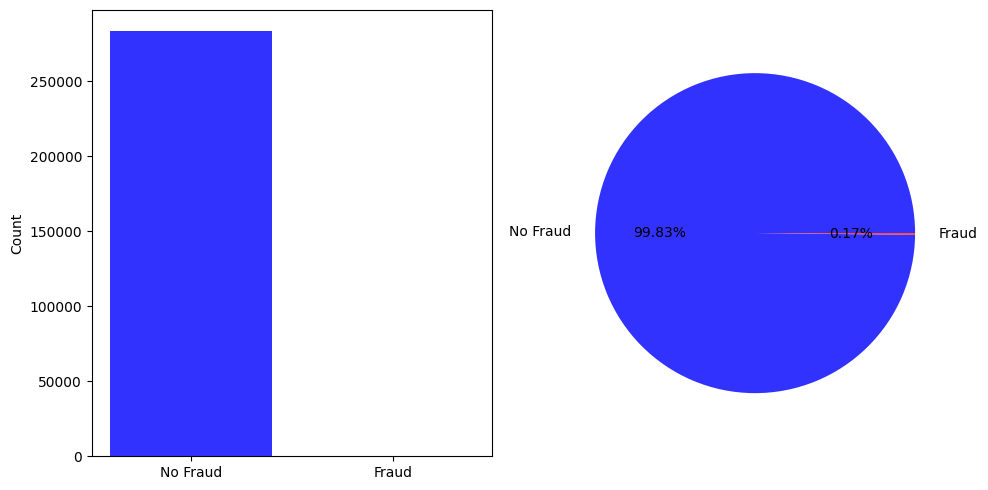

In [49]:
cmap = matplotlib.cm.get_cmap("bwr")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
count = data["Class"].value_counts()
perc_count = data["Class"].value_counts(normalize=True)
labels = ["No Fraud", "Fraud"]
ax[0].bar(count.index, count.values, color=[cmap(0.1), cmap(0.9)])
ax[0].set_xticks([0, 1], labels)
ax[0].set_ylabel("Count")
ax[1].pie(
    perc_count,
    labels=labels,
    autopct="%1.2f%%",
    radius=1,
    labeldistance=1.15,
    colors=[cmap(0.1), cmap(0.9)],
)
fig.tight_layout()
plt.show()


In [11]:
print(
    f"Percentage of No Fraud data:{round(perc_count[0],4) * 100}%\n Percentage of Fraud data:{round(perc_count[1],4)*100}%"
)


Percentage of No Fraud data:99.83%
 Percentage of Fraud data:0.16999999999999998%


As expected our dataset is highly imbalance, with only 492 entries belonging to the minority group.  

### Model Selection

#### Process Layout

Now that we have prepared our dataset is time to build some Machine Learning problems and identify which one has the best performance and is the best fit for our application.  

The following classification algorithms will be compared:
1. **Logistic Regression**
2. **K Nearest Neighbors**
3. **Random Forest**
4. **Support Vector Machine**

For all the algorithms we will perform hyperparameter tunning and the best algorithms will be compared using a hold out test.  

Because the class distribution is highly imbalanced, most machine learning algorithms will have poor performance.This
happens, because there are too little data for the algorithm to be able to learn the decision boundary. Therefore, we will need to perform some extra steps to boost the predictive capability of the algorithms:

1. **Step 1**: We will split our dataset in to a train and a test dataset using stratification. Stratification will ensure that we have the same distribution of target classes in both datasets.
2. **Step 2**: Use the training dataset to develop algorithms. For each algorithm we will perform hyperparameter tunning using either grid search or random search. Also, we will perform cross validation to identify how well our best algorithms generalize. Morover, within each fold of our cross validation we will perform oversampling in order to achieve equal distributions of fraudulent and non fraudulent transaction in our training sets:

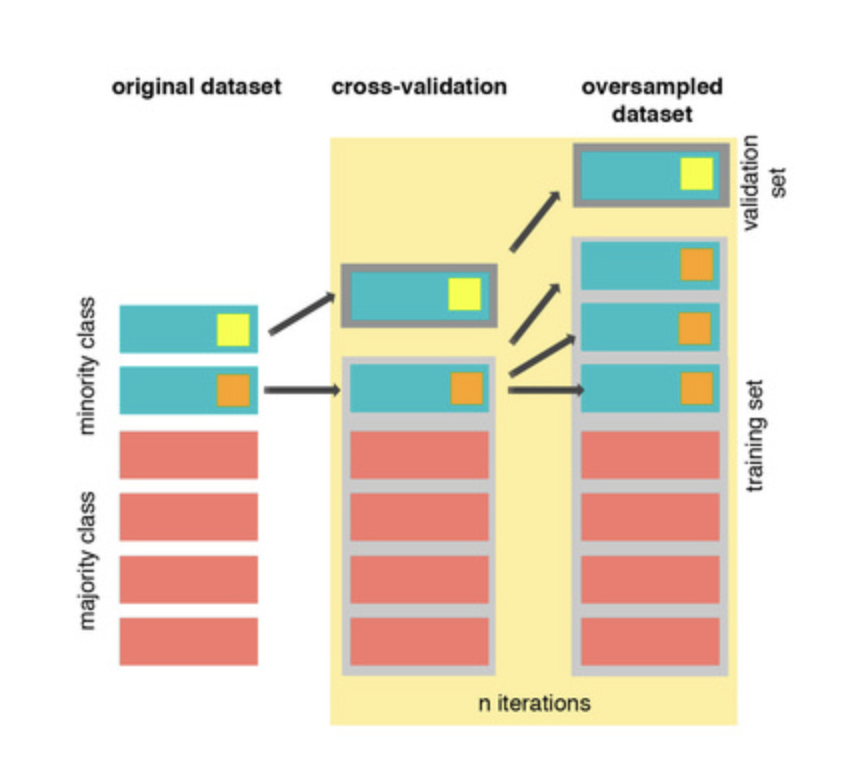


For this activity we will use the *Synthetic Minority Oversampling Technique SMOTE*.This technique allow us to sunthesize new samples of the minority class, blancing in that way our dataset. More information can be found here:
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

Note: Oversampling within the each fold and not before in order to prevent data leackage. The following article nicely exmplaing this problem: https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation

For performing *SMOTE* we will use the imblearn python package (https://pypi.org/project/imbalanced-learn/), that provides a number of different re-sampling techniques. For the grid and random search we will use the *GridSearchCV* and *RandomizedSearchCV* classes from sklearn. This classes include cross validation.

3. **Step 3**: After identifying the best parameters for each algorithm we will compare their performance using the hold out dataset (test set).

Note: An extensive explanation on the error metrics used for evaluation the models performance is provided in a later section (Error Metrics). For the model development we will use the Area Under the Precision-Recall Curve metric, which is a recommended classification metric for imbalanced classification problems.

#### Modelling

Before starting trying different models we will need to split our dataset into a train and test subset, using stratification.

https://towardsdatascience.com/imbalanced-class-sizes-and-classification-models-a-cautionary-tale-part-2-cf371500d1b3

In [12]:
predictors = data.columns[:-1]
X = np.array(data[predictors])
y = np.array(data["Class"].values)
# We keep 20% of the data for testing and use 80% for training and validating the model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.2
)


In [13]:
def ident_best_model(
    X: np.array,
    y: np.array,
    algo: t.Callable,
    sampling: t.Callable,
    params: t.Dict,
    cv_folds: int,
    scoring: str,
    grid: bool,
):
    """"""
    pipeline = Pipeline([("sampling", sampling), ("clf_model", algo)])
    if grid:
        model = GridSearchCV(
            pipeline, param_grid=params, scoring=scoring, cv=cv_folds, n_jobs=-1
        )
    else:
        model = RandomizedSearchCV(
            pipeline,
            param_distributions=params,
            n_iter=50,
            scoring=scoring,
            cv=cv_folds,
            n_jobs=-1,
        )

    return model.fit(X, y)


In [14]:
sampling = SMOTE(random_state=42, sampling_strategy="minority")


#### 1. Logistic Regression

We deceided to investigate the following hyperparameters of ligistic regression:  
   * **C**: Inverse of regularization strength, can take values from 0-1.
   * **Regularization or penalty**: Adding regularisation intends to discourage overfitting and reduce the models generalization error.

In [15]:
# We use the liblinear solver as is recommended for larg-scale classification problems and can habdle both l1 and l2 classification
lr = LogisticRegression(random_state=42, max_iter=300, solver="liblinear")
lr_params = {
    "clf_model__C": [0.01, 0.1, 1, 10, 100],
    "clf_model__penalty": ["l2", "l1"],
}

lr_model = ident_best_model(
    X=X_train,
    y=y_train,
    algo=lr,
    sampling=sampling,
    params=lr_params,
    cv_folds=5,
    scoring="roc_auc",
    grid=True,
)


/Users/despoinamoschou/Library/Caches/pypoetry/virtualenvs/fraud-detection-krku-eO0-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [16]:
lr_model.best_estimator_


Pipeline(steps=[('sampling',
                 SMOTE(random_state=42, sampling_strategy='minority')),
                ('clf_model',
                 LogisticRegression(C=0.01, max_iter=300, random_state=42,
                                    solver='liblinear'))])

The best hyperparameters for the Logistic Refression model are C=0.01, with 300 max iterations and 'l2' regularization.

In [17]:
print(f"This model is able to achieve a {round(lr_model.best_score_,3)} AUC_ROC score.")


This model is able to achieve a 0.983 AUC_ROC score.


In [18]:
# Fix this Dataframe
pd.DataFrame(lr_model.cv_results_).drop("params", axis=1)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf_model__C,param_clf_model__penalty,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.192912,0.111985,0.021065,0.002441,0.01,l2,0.970667,0.982366,0.998662,0.982772,0.978093,0.982512,0.009173,1
1,4.745014,0.258993,0.020799,0.002555,0.01,l1,0.969926,0.981881,0.998649,0.981655,0.977632,0.981949,0.009404,10
2,3.808006,0.199241,0.021112,0.003143,0.1,l2,0.970038,0.982511,0.998674,0.982984,0.977946,0.982431,0.009358,2
3,7.250147,0.845208,0.017837,0.001704,0.1,l1,0.970045,0.982435,0.998656,0.982867,0.977783,0.982357,0.009364,9
4,4.194976,0.276714,0.018154,0.004472,1,l2,0.969883,0.982537,0.998675,0.982923,0.977942,0.982392,0.009399,3
5,7.953867,1.348953,0.017920,0.001658,1,l1,0.970001,0.982479,0.998665,0.982951,0.977805,0.982380,0.009378,8
6,4.226851,0.394683,0.016931,0.003776,10,l2,0.969833,0.982540,0.998674,0.982913,0.977941,0.982380,0.009412,7
7,9.248582,2.246325,0.016969,0.004418,10,l1,0.970001,0.982482,0.998666,0.982893,0.977879,0.982384,0.009370,6
8,4.105277,0.379031,0.017797,0.001644,100,l2,0.969857,0.982541,0.998675,0.982913,0.977941,0.982385,0.009406,4
9,6.488748,1.121950,0.011672,0.001345,100,l1,0.970001,0.982482,0.998666,0.982892,0.977880,0.982384,0.009370,5


#### 2. K-Nearest Neighbours

We deceided to investigate the following hyperparameters of the K-nearest neighbours algorithm:  
   * **Number of neighbors**: Number of neighbors used for determining the classification of one point.
   * **Distance Metric**: The dsitance metric to be used when claculating the similarity between points.

In [19]:
knn = KNeighborsClassifier()
knn_params = {
    "clf_model__n_neighbors": list(range(5, 106, 10)),
    "clf_model__metric": ["euclidean", "minkowski"],
}
knn_model = ident_best_model(
    X=X_train,
    y=y_train,
    algo=knn,
    sampling=sampling,
    params=knn_params,
    cv_folds=5,
    scoring="roc_auc",
    grid=True,
)


/Users/despoinamoschou/Library/Caches/pypoetry/virtualenvs/fraud-detection-krku-eO0-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [20]:
knn_model.best_estimator_


Pipeline(steps=[('sampling',
                 SMOTE(random_state=42, sampling_strategy='minority')),
                ('clf_model',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=105))])

The best K Nearest Neighbors model uses the euclidean distance and 81 neighbors.

In [71]:
print(
    f"This model is able to achieve a {round(knn_model.best_score_,3)} AUC_ROC score."
)


This model is able to achieve a 0.955 AUC_ROC score.


In [22]:
pd.DataFrame(knn_model.cv_results_).drop("params", axis=1)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf_model__metric,param_clf_model__n_neighbors,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.124867,0.011682,65.261367,0.157365,euclidean,5,0.906311,0.906132,0.947002,0.920481,0.940359,0.924057,0.016978,21
1,0.124590,0.008893,69.832701,8.925512,euclidean,15,0.912657,0.919089,0.953303,0.926724,0.946657,0.931686,0.015728,19
2,0.096972,0.006772,59.804476,0.195629,euclidean,25,0.918998,0.925394,0.959642,0.926416,0.959582,0.938006,0.017823,17
3,0.110583,0.026823,69.884745,12.112367,euclidean,35,0.918776,0.925135,0.965989,0.926174,0.959461,0.939107,0.019559,15
4,0.092561,0.004996,61.264875,0.216020,euclidean,45,0.918545,0.944610,0.972322,0.925912,0.959332,0.944144,0.020063,13
5,0.092231,0.018101,64.399087,4.661573,euclidean,55,0.924867,0.944422,0.972242,0.925622,0.959205,0.945271,0.018572,11
6,0.092167,0.004109,64.870066,0.041004,euclidean,65,0.924642,0.944252,0.978550,0.925359,0.965519,0.947664,0.021503,9
7,0.104305,0.028041,65.185725,0.142213,euclidean,75,0.924454,0.950616,0.984878,0.925098,0.965407,0.950091,0.023353,7
8,0.102278,0.009791,64.713830,0.170918,euclidean,85,0.930790,0.950493,0.984848,0.931258,0.965310,0.952540,0.020674,3
9,0.086305,0.004766,64.698822,0.138404,euclidean,95,0.930608,0.950288,0.984825,0.931043,0.965250,0.952403,0.020746,5


#### 3. Decision Tree

We deceided to incvestigate the following hyperparameters of the K-nearest neighbours algorithm:
   * **Criterion**: Function used for measuring the quality of a split. The supported functions are "gini" for the Gini impurity and "entropy" for the information gain.
   * **Maximum Depth**: The maximum depth of the tree.
   * **Manimum samples split**: This hyperparameter caps the number of leaf nodes in a decision tree
   * **Max Features**: Maximum number of features to consider at each split

In [23]:
dt = DecisionTreeClassifier(random_state=42)
dt_params = {
    "clf_model__criterion": ["gini", "entropy"],
    "clf_model__max_depth": list(range(5, 25)),
    "clf_model__min_samples_split": list(range(5, 31, 5)),
    "clf_model__max_features": list(range(5, 25, 5)),
}
dt_model = ident_best_model(
    X=X_train,
    y=y_train,
    algo=dt,
    sampling=sampling,
    params=dt_params,
    cv_folds=5,
    scoring="roc_auc",
    grid=False,
)


In [24]:
dt_model.best_estimator_


Pipeline(steps=[('sampling',
                 SMOTE(random_state=42, sampling_strategy='minority')),
                ('clf_model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        max_features=15, min_samples_split=15,
                                        random_state=42))])

The best Decision Tree model uses:  
    * entropy as the split criterion  
    * has a max depth of 7  
    * uses a maximum of 10 features per split  
    * the minimum number of samples to perform a split is 10  

In [70]:
print(f"This model is able to achieve a {round(dt_model.best_score_,3)} AUC_ROC score.")


This model is able to achieve a 0.944 AUC_ROC score.


#### 4. Random Forest

For the random forest model we will play with the same hyperparameters as for the decision tree algorithm above, but we will aslo tune the number of estimators parameter, which defines the number of decision tree regressors used by the algorithm.

A lot of them so for that reason we will use RandomSearchCV

In [33]:
start = time.time()
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_params = {
    "clf_model__n_estimators": list(range(50, 250, 10)),
    "clf_model__criterion": ["gini", "entropy"],
    "clf_model__max_depth": list(range(5, 25)),
    "clf_model__min_samples_split": [10, 20],
    "clf_model__max_features": list(range(5, 25, 5)),
}

rf_model = ident_best_model(
    X=X_train,
    y=y_train,
    algo=rf,
    sampling=sampling,
    params=rf_params,
    cv_folds=5,
    scoring="roc_auc",
    grid=False,
)
end = time.time()

print(f"Execution time: {end-start}")


Execution time: 17700.785435914993


In [35]:
rf_model.best_estimator_


Pipeline(steps=[('sampling',
                 SMOTE(random_state=42, sampling_strategy='minority')),
                ('clf_model',
                 RandomForestClassifier(max_depth=14, max_features=5,
                                        min_samples_split=10, n_estimators=220,
                                        n_jobs=-1, random_state=42))])

The best Random Forest Classifier is using the 'gini' criterion, uses max 15 features for deceiding splits, needs minimum 10 samples for a split, has a max dept of 14 and is using 220 trees as estimators.

In [38]:
print(f"This model is able to achieve a {round(rf_model.best_score_,3)} AUC_ROC score.")


This model is able to achieve a 0.982 AUC_ROC score.


In [39]:
pd.DataFrame(rf_model.cv_results_).drop("params", axis=1)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf_model__n_estimators,param_clf_model__min_samples_split,param_clf_model__max_features,param_clf_model__max_depth,param_clf_model__criterion,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,157.112092,15.147327,0.391990,0.144345,140,20,5,6,gini,0.963628,0.977355,0.998905,0.973918,0.980834,0.978928,0.011527,11
1,1490.272613,84.662427,0.646494,0.087778,220,20,15,16,gini,0.957045,0.949204,0.996689,0.972453,0.976416,0.970361,0.016487,38
2,1153.770609,26.310340,0.476234,0.087381,190,20,15,18,entropy,0.935540,0.965017,0.994199,0.957544,0.980685,0.966597,0.020047,45
3,201.159560,5.203722,0.240115,0.063457,100,20,5,18,entropy,0.944568,0.971168,0.998074,0.970251,0.985641,0.973940,0.017908,32
4,217.925896,13.342775,0.370168,0.109668,100,10,5,19,entropy,0.948171,0.960018,0.997688,0.976362,0.987686,0.973985,0.017981,31
5,1608.712168,73.573932,0.549910,0.052951,220,20,15,19,gini,0.947014,0.973812,0.997210,0.957210,0.983418,0.971733,0.017955,35
6,103.452460,20.198746,0.160093,0.030452,70,10,5,8,gini,0.961440,0.973627,0.998980,0.973422,0.985616,0.978617,0.012733,12
7,1152.986034,23.019178,0.166557,0.027920,100,10,20,23,gini,0.948791,0.945145,0.995363,0.954100,0.975566,0.963793,0.018984,46
8,142.576399,2.577385,0.172384,0.057436,80,20,5,9,entropy,0.963697,0.984065,0.997845,0.980365,0.984168,0.982028,0.010934,3
9,1438.849633,41.062238,0.732437,0.162188,220,10,20,10,gini,0.932047,0.966542,0.995711,0.968076,0.979278,0.968331,0.020925,43


### Model Comparison

No that we have performed hyperparameter tunning and identified the best models, it's time to test their performance on the hold out test and identify the best model for our application.

#### Error metrics

It is important to select evaluation metrics based on what is importan for the problem we are solving. In this activity we are trying to identify fraudulent transactions. The standard metrics used for classification problems (classification accuracy and classification error) are deemed misleading for our problem as we have a highly imbalansed datasets, and won't tell the full story.

Our main aim is to create a classifier that is able to identify correctly the minority class (e.g. fraudulent transaction). Therefore the following performance metrics will be utilised:
1. **Recall**: Refers to the true positive rate and summarizes how well the positive class was predicted.  
   **Recall = TruePositive / (TruePositive + FalseNegative)**
2. **Precision**: Summarizes the fraction of examples assigned the positive class that belong to the positive class.  
   **Precision = TruePositive / (TruePositive + FalsePositive)**
3. **F-score**: Precision and recall can be combined into a single score that seeks to balance both concerns, called the F-score.  
    **F-score = (2 * Precision * Recall) / (Precision + Recall)**
4. **Area Under the Receiver Operating Characteristic Curve (ROC AUC)**: This metric represents the model's ability to separate the 2 target classe. A value of 1 means that the classifier can perfectly distinguish the positive from the negative class, while a value of 0 shows that the classifier predicts all positive samples as negatives and vise verca.

Let's now perform the model comparison!

In [41]:
models = {
    "Logistic Regression": lr_model,
    "Decision Trees": dt_model,
    "Random Forest": rf_model,
    "K-Nearest Neighbor": knn_model,
}


In [69]:
metrics = []
index = []
cm = []
for k, v in models.items():
    y_pred = v.predict(X_test)
    y_pred_proba = v.predict_proba(X_test)[:, 1]
    d = {
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "auc_roc": roc_auc_score(y_test, y_pred_proba),
        "f1_score": f1_score(y_test, y_pred),
    }
    metrics.append(d)
    index.append(k)
    cm.append(confusion_matrix(y_test, y_pred))

pd.DataFrame(metrics, index=index)


,precision,recall,auc_roc,f1_score
Logistic Regression,0.053966,0.873684,0.961972,0.101653
Decision Trees,0.030757,0.842105,0.948188,0.059347
Random Forest,0.760417,0.768421,0.976591,0.764398
K-Nearest Neighbor,0.086589,0.863158,0.938993,0.157390


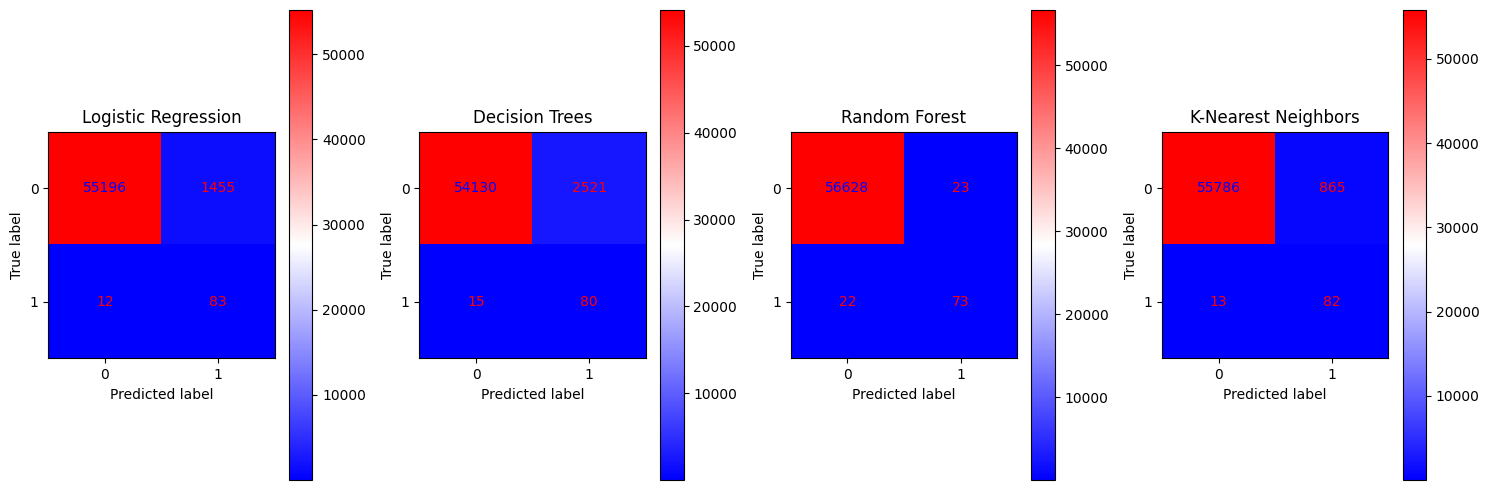

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ConfusionMatrixDisplay(cm[0]).plot(ax=ax[0], cmap=cmap)
ConfusionMatrixDisplay(cm[1]).plot(ax=ax[1], cmap=cmap)
ConfusionMatrixDisplay(cm[2]).plot(ax=ax[2], cmap=cmap)
ConfusionMatrixDisplay(cm[3]).plot(ax=ax[3], cmap=cmap)
ax[0].set_title("Logistic Regression")
ax[1].set_title("Decision Trees")
ax[2].set_title("Random Forest")
ax[3].set_title("K-Nearest Neighbors")
fig.tight_layout()


In [62]:
lr_y_pred = lr_model.predict(X_test)
knn_y_pred = knn_model.predict(X_test)
dt_y_pred = dt_model.predict(X_test)
rf_y_pred = rf_model.predict(X_test)


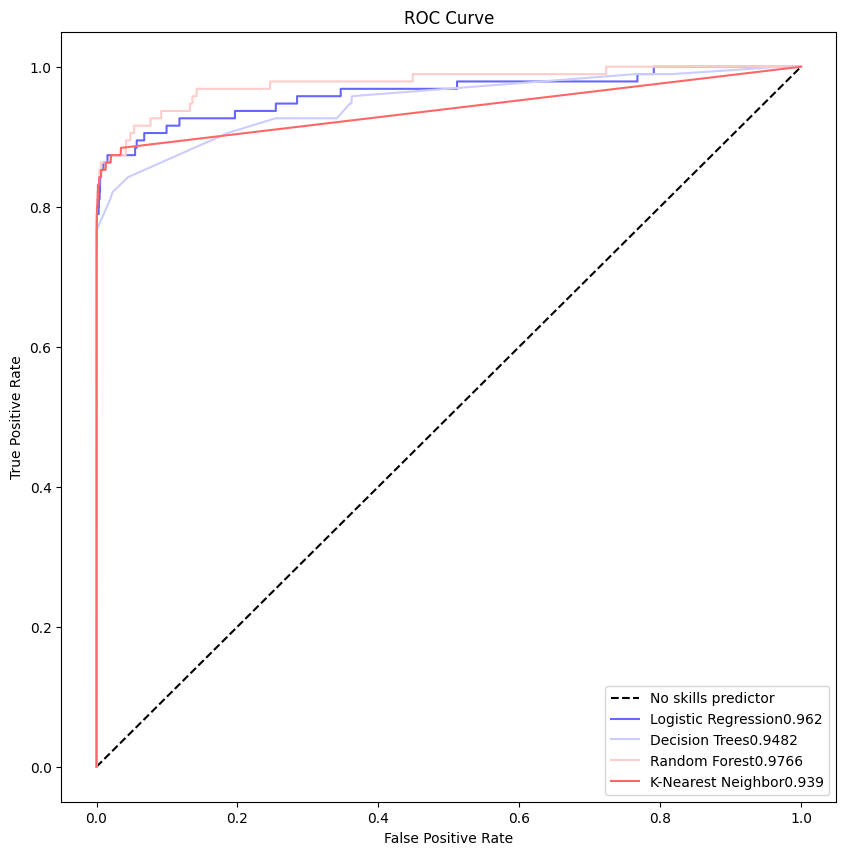

In [73]:
# Generate the no skill predictor (constanly chooses the majority class)
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(ns_fpr, ns_tpr, color="black", linestyle="dashed", label='No skills predictor')
c = [0.2, 0.4, 0.6, 0.8]
i = 0
for k, v in models.items():
    y_pred_proba = v.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    # Fix value of auc
    ax.plot(fpr, tpr, label=k + str(round(auc, 4)), color=cmap(c[i]))
    ax.legend(loc=4)
    i += 1

ax.set_title("ROC Curve")
ax.set_ylabel("True Positive Rate")
ax.set_xlabel("False Positive Rate")
plt.show()


Based on the above error metric analysis we can see the following:
* Logistic Regression (LR) and Random Forest (RF) were the best performing models in terms of the quality of classification as they obtained AUCs of 0.962 and 0.9766 respectively.
* In terms of which model predicts better the positive class (fraud), the LR model is the winner with a recall of 0.874. K-Nearest Nearest neighbours come second with a recall of 0.863, while Random Forest come last with a score of 0.76.
* Using now the precision metric we can see, only the RF model was able to achieve a good score (0.76). All the other models have a higher rate of missclassifying negative instances as positives. This is their trade of for their higher recall metrics.
* Finally, the RF model is the one that is the best in terms of the f1-score, which means that is the model that balances the best precision and recall.

In terms of a credit card fraud application it is important to:
1. Be able to identify fraudulent activities and block them on the spot (e.g have high recall)
2. Have a low rate of missclassifying normal credit card transactions (e.g have high precision), as from a customer experience point of view you don't want to block your customers card with no reason and create frustration.

So based on analysis we can conclude that the Random Forest model, is the best classifier for this application as it provides a balance between the 2 objectives. 

Note: This is an initial analysis, that showcases that the potential of the Random Forest model. If we had more computational resources we could perform a better hyperparameter tunning on our model and potential increase it's performance.
